# UN Analysis

Analysis of UN actors in agreement-actor networks.


In [15]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [16]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
print(data_dict.keys())


dict_keys(['agreements_dict', 'dates_dict', 'nodes_data', 'nodes_header', 'links_data', 'links_header', 'agreement_vertices', 'actor_vertices', 'vertices_dict', 'color_map', 'matrix'])


In [3]:
print(len(data_dict['agreement_vertices']))
print(len(data_dict['actor_vertices']))

#print(data_dict['vertices_dict']['IGO_49'])


1642
1096


## Collect UN actor indices and IDs

In [4]:

un_actors_list = []

for actor_index,actor_id in enumerate(data_dict['actor_vertices']):
    if len(actor_id) == 0:
        continue
    if not actor_id.startswith('IGO_') and not actor_id.startswith('COA_'):
        continue
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    if 'United Nations' in actor_name or actor_name.startswith('UN') or ' UN' in actor_name:
        un_actors_list.append((actor_index,actor_id,actor_name))

un_actors_list = sorted(un_actors_list,key=lambda t:t[2])

# Print ready for insertion in LaTex document
latex = False
if latex:
    for t in un_actors_list:
        s = t[2] + ' & ' + '\\_'.join(t[1].split('_')) + ' \\\\'
        print(s)
        print('\\hline')
    

## Get UN actor biadjacency matrices

There are two matrices:

1. UN-only matrix: 
    - Rows are agreements that have at least one UN signatory
    - Columns are UN actors
2. UN actors and non-UN co-signatories matrix:
    - Rows are agreements that have at least one UN signatory (as above)
    - Columns are all the actors who are signatories to the row agreements

The indices of the agreements and actors that constitute the above matrices are:

- agreement_indices: Indices into `data_dict['agreement_vertices']` and therefore rows of `data_dict['matrix']`
- un_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors only
- actor_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors and co-signatories


In [5]:
un_indices = [t[0] for t in un_actors_list]

matrix = data_dict['matrix']

# Reduce the matrix to UN actor columns only
reduced_matrix = matrix[np.ix_(range(0,matrix.shape[0]),un_indices)]
# Get indices of agreement row containing at least one non-zero value, i.e., agreements signed by at least
# one of the UN actors
indices = np.nonzero(reduced_matrix)
agreement_indices = list(set(indices[0]))

# This is the UN actors only matrix
un_matrix = matrix[np.ix_(agreement_indices,un_indices)]
print(un_matrix.shape)

# Reduce the complete matrix to the UN agreement rows and all actors
reduced_matrix = matrix[np.ix_(agreement_indices,range(0,matrix.shape[1]))]

# Get indices of all non-zero actor columns for the agreement rows, i.e., UN actors and co-signatories
indices = np.nonzero(reduced_matrix)
actor_indices = list(set(indices[1]))

# This is the UN actors and non-UN co-signatories matrix
un_cosign_matrix = matrix[np.ix_(agreement_indices,actor_indices)]
print(un_cosign_matrix.shape)
print()

print('There are',un_matrix.shape[0],'agreements signed by at least one of',un_matrix.shape[1],\
      'UN actors, and one or more of',un_cosign_matrix.shape[1] - un_matrix.shape[1],'non-UN actors')

(371, 26)
(371, 536)

There are 371 agreements signed by at least one of 26 UN actors, and one or more of 510 non-UN actors


### Analysis: UN-only

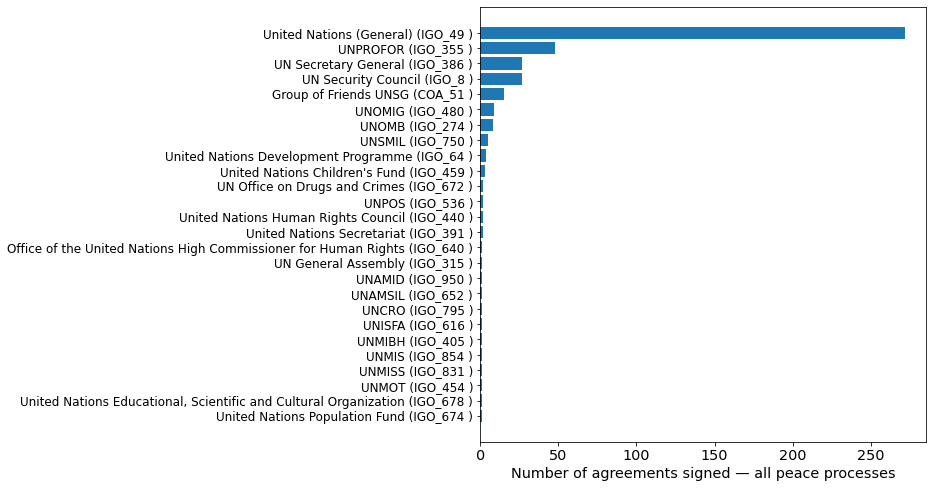

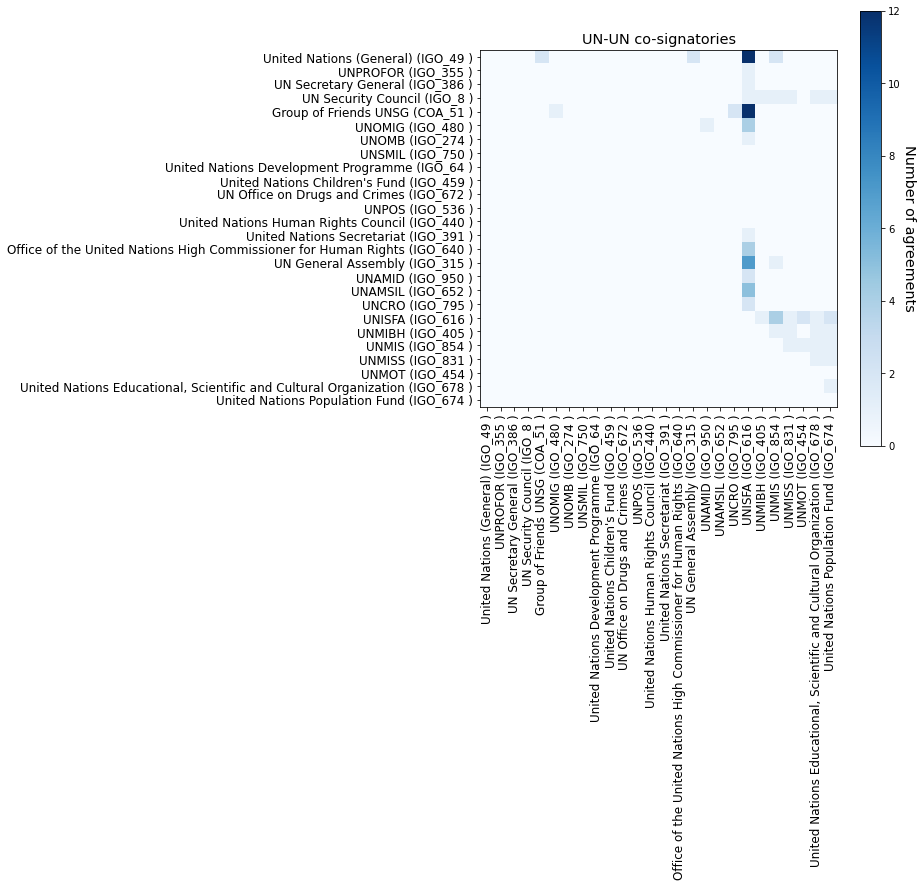

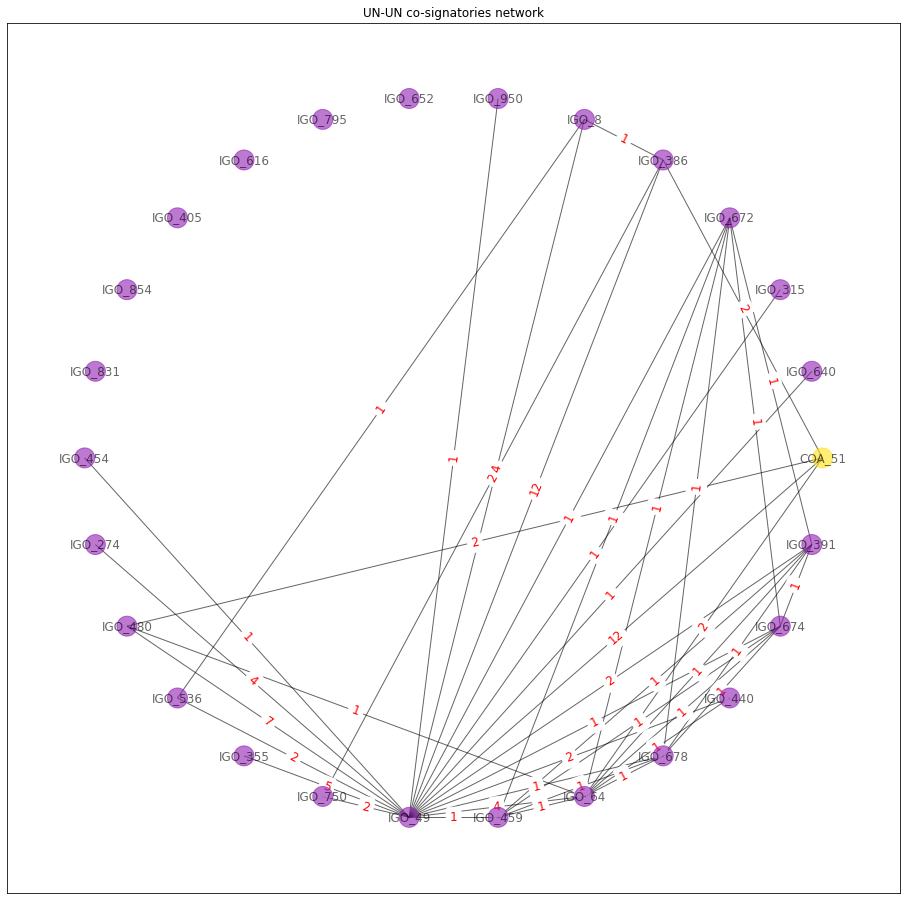

In [6]:
# Get UN actor labels

co_matrices = get_cooccurrence_matrices(un_matrix)
# Upper triangle of actor co-occurence matrix
actor_upper = np.triu(co_matrices[0],k=1)


# Co-occurrence diagonal is the columns marginal of the UN-only biadjacency matrix
diag = np.diag(co_matrices[0])
a = list(zip(diag,un_actors_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a]

# Number of agreements signed
latex = False
if latex:
    for t in a:
        s = t[1][2] + ' & ' + '\\_'.join(t[1][1].split('_'))  + ' & ' + str(t[0]) + ' \\\\'

        #s = t[1][2] + ' & ' + str(t[0]) + ' \\\\'
        print(s)
        print('\\hline')


f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag)),diag)
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
plt.xticks(fontsize='x-large')
plt.xlabel('Number of agreements signed — all peace processes',fontsize='x-large')
plt.gca().invert_yaxis()
plt.show()

# Heat map
f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(label_list)),label_list,rotation=90,fontsize='large')
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.title('UN-UN co-signatories',fontsize='x-large')
plt.show()

# Network diagram
display_comatrix_as_networkx_graph(co_matrices[0],un_indices,data_dict['actor_vertices'],data_dict,\
                                   title='UN-UN co-signatories network')

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_actors_list[t[0]][1],un_actors_list[t[0]][2],\
           un_actors_list[t[1]][1],un_actors_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[4],reverse=True)

# Output for LaTex document
latex = False
if latex:
    for t in scores:
        s = t[1] + ' (' + '\\_'.join(t[0].split('_')) + ') & ' +\
            t[3] + ' (' + '\\_'.join(t[2].split('_')) + ') & ' + str(t[4]) + ' \\\\'
        print(s)
        print('\\hline')

# Locate the singletons
singleton_indices = [index for index,row in enumerate(actor_upper) if np.all(row == 0) and\
                        np.all(actor_upper[:,index] == 0)]
latex = False
if latex:
    for index in singleton_indices:
        singleton_data = un_actors_list[index]
        s = singleton_data[2] + ' (' + '\\_'.join(singleton_data[1].split('_')) + ')' + ' \\\\'
        print(s)
        print('\\hline')



### Analysis: UN and non-UN co-signatories

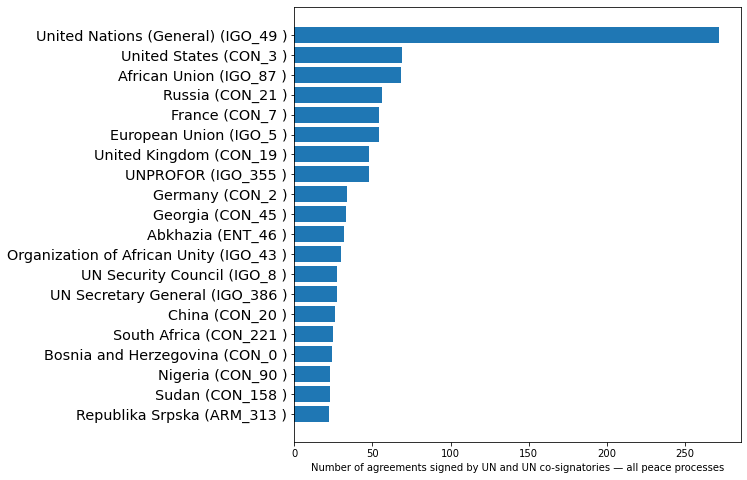

1287


In [7]:
co_matrices = get_cooccurrence_matrices(un_cosign_matrix)
actor_upper = np.triu(co_matrices[0],k=1)


un_cosign_actor_list = []
for actor_index in actor_indices:
    actor_id = data_dict['actor_vertices'][actor_index]
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    un_cosign_actor_list.append((actor_index,actor_id,actor_name))

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_cosign_actor_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a[0:20]]

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag[0:20])),diag[0:20])
plt.yticks(range(0,len(label_list)),label_list,fontsize='x-large')
plt.xlabel('Number of agreements signed by UN and UN co-signatories — all peace processes')
plt.gca().invert_yaxis()
plt.show()

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_cosign_actor_list[t[0]],un_cosign_actor_list[t[1]],actor_upper[t[0]][t[1]]) for t in z if\
             un_cosign_actor_list[t[0]][0] in un_indices or un_cosign_actor_list[t[1]][0] in un_indices]
scores = sorted(scores,key=lambda t:t[2],reverse=True)


print(len(scores))
latex = False
if latex:
    for t in scores[0:30]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')

latex = False
if latex:
    for t in scores[-15:]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')



## Case study: United Nations (General)

In [53]:
actor_id = 'IGO_49'
actor_index = data_dict['actor_vertices'].index(actor_id)
actor_name = get_actor_name(actor_id,data_dict)
actor_label = actor_name + ' (' + actor_id + ' )'


### Co-signatory analysis

In [57]:
co_matrices = get_cooccurrence_matrices(data_dict['matrix'])
cosign_ids = [data_dict['actor_vertices'][i] for i,v in enumerate(co_matrices[0][actor_index]) if v > 0]

#print(cosign_ids)

### Time series analysis

In [46]:
year_list = []
for i,agreement_id in enumerate(data_dict['agreement_vertices']):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_list.append(ag_year)
# Sort by year    
year_list = sorted(set(year_list))
print(year_list)

# Total of agreements for each year
ag_year_vector = [0]*len(year_list)
for agreement_id in data_dict['agreement_vertices']:
    year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_index = year_list.index(year)
    ag_year_vector[year_index] += 1
    
print(sum(ag_year_vector))


[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
1642
[44, 81, 79, 85, 91, 64, 65, 69, 65, 82, 59, 57, 50, 50, 46, 29, 59, 33, 56, 32, 28, 47, 57, 35, 51, 46, 38, 29, 28, 17, 28, 24, 17, 1]


#### Aggregated

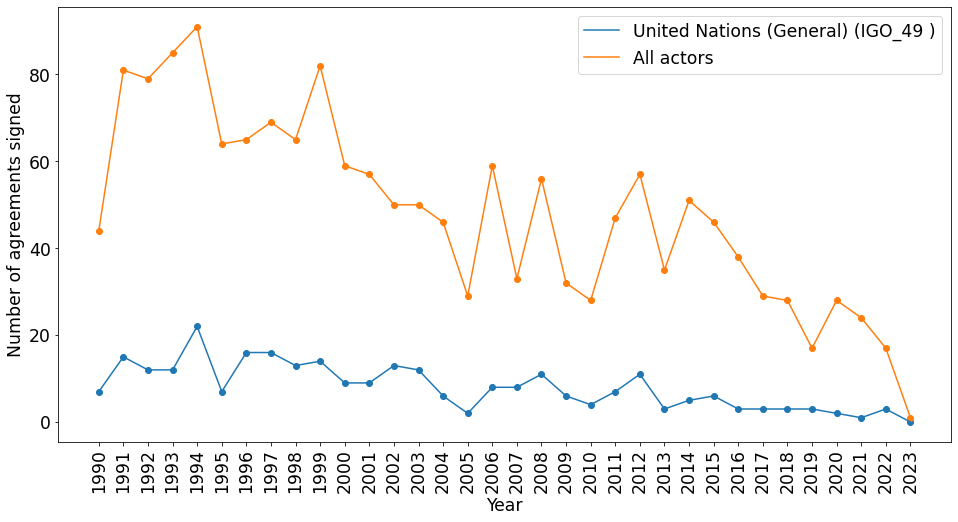

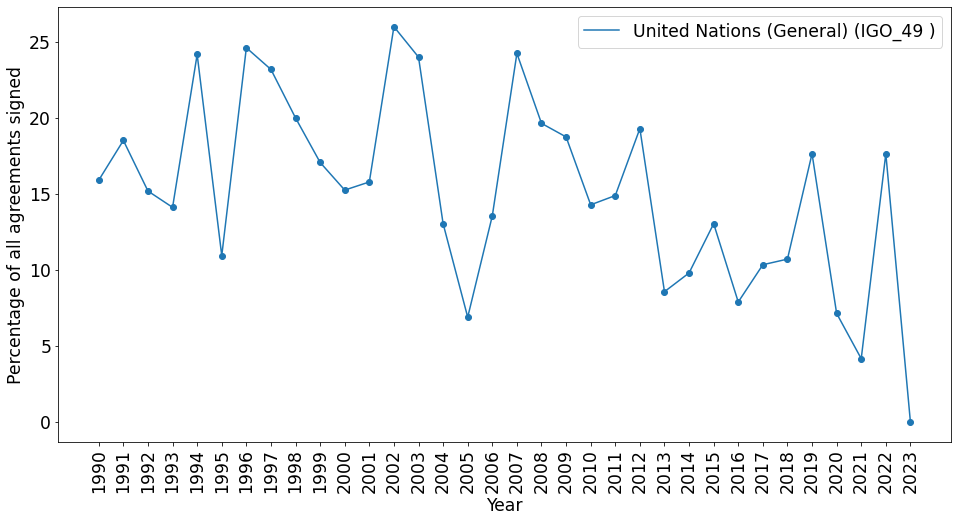

In [70]:

year_vector = [0]*len(year_list)

# Get agreements for IGO_49
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]
#print(len(agreement_ids))

matrix_t = data_dict['matrix'].T
for j,v in enumerate(matrix_t[actor_index]):
    if v == 0:
        continue
    agreement_id = data_dict['agreement_vertices'][j]
    year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_index = year_list.index(year)
    year_vector[year_index] += 1

#print(len(year_vector),sum(year_vector))
#print(list(zip(year_list,ag_year_vector,year_vector)))


x = range(0,len(year_vector))

f = plt.figure(figsize=(16,8))
plt.plot(x,year_vector,label=actor_label)
plt.scatter(x,year_vector)
plt.plot(x,ag_year_vector,label='All actors')
plt.scatter(x,ag_year_vector)
plt.ylabel('Number of agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# As proportion of agreements in a year
percent_vector = [round((v/ag_year_vector[i])*100,3) for i,v in enumerate(year_vector)]

f = plt.figure(figsize=(16,8))
plt.plot(x,percent_vector,label=actor_label)
plt.scatter(x,percent_vector)
plt.ylabel('Percentage of all agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()


#### Get agreements in a given year

In [73]:
year = 2015

# Ageements signed by actor
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]

# Filter by year
agreements_in_year = [v for v in agreement_ids if int(str(data_dict['dates_dict'][v])[0:4])==year]

latex = True
if latex:
    for agreement_id in agreements_in_year:
        agreement_name = get_agreement_name(agreement_id,data_dict)
        s = '\\_'.join(agreement_id.split('_'))  + ' & ' + agreement_name + ' \\\\'
        print(s)
        print('\\hline')
    

['AGT_1367', 'AGT_1357', 'AGT_2035', 'AGT_1652', 'AGT_1366', 'AGT_1436']
AGT\_1367 & Arrangement sécuritaire pour une cessation des hostilités \\
\hline
AGT\_1357 & Agreement on the Resolution of the Conflict in the Republic of South Sudan (ARCSS) \\
\hline
AGT\_2035 & Agreement between the Transitional Government and the armed groups on the principles of disarmament, demobilization, reintegration and repatriation and of integration into the uniformed State forces of the Central African Republic (DDRR Agreement) \\
\hline
AGT\_1652 & Final declaration on the results of the Syria Talks in Vienna as agreed by participants \\
\hline
AGT\_1366 & Relevé de Conclusions des Consultations Préparatoires a la mise en œuvre de l'Accord pour la Paix et la Reconciliation au Mali Issu du Procesus d'Alger \\
\hline
AGT\_1436 & The Nationwide Ceasefire Agreement (NCA) between The Government of the Republic of the Union of Myanmar and the Ethnic Armed Organizations (EAO) \\
\hline
